## Point Net Implementation

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
## Point Net Implementation
import trimesh
import gc


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 646.2/646.2 kB 2.6 MB/s eta 0:00:00


### Dataset

In [2]:
class PointCloud(Dataset):

    def __init__(self, root_dir, n=50176,train = True):
        self.classes = os.listdir(root_dir)
        self.root_dir = root_dir
        self.n = n
        self.labels = {}
        self.train = train
        
        for i in range(len(self.classes)):
            self.labels[self.classes[i]] = i
        
        trainls = []
        df = pd.DataFrame(trainls)
        for i in range(len(self.classes)):
            folderpath = self.root_dir + "/" + self.classes[i] + "/train/"  
            for j in os.listdir(folderpath):
                trainls.append(folderpath + j)  
        self.trainfilepath = pd.DataFrame(trainls)

        testls = []
        for i in range(len(self.classes)):
            folderpath = self.root_dir + "/" + self.classes[i] + "/test/"  
            for j in os.listdir(folderpath):
                testls.append(folderpath + j) 
        self.testfilepath = pd.DataFrame(testls)
                    
    def __len__(self):
        if self.train == True:
            return len(self.trainfilepath)
        if self.train == False:
            return len(self.testfilepath)

    def __getitem__(self, idx):
        # idx is row number
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        
        if self.train == True:
            lslabel = np.zeros(10)
            path = self.trainfilepath.iloc[idx][0]
            points = trimesh.load(self.trainfilepath.iloc[idx][0]).sample(self.n)
            for i in self.labels.keys():
                if i in path:
                    lslabel[self.labels[i]] = 1
                
            return torch.tensor(points),lslabel  
                    
        elif self.train == False:  
            ls = 0
            path = self.testfilepath.iloc[idx][0]
            points = trimesh.load(self.testfilepath.iloc[idx][0]).sample(self.n)
            for i in self.labels.keys():
                if i in path:
                    ls = self.labels[i]
            return torch.tensor(points),ls
        

In [3]:
pointcloudtrain_dataset = PointCloud(root_dir='../input/modelnet10-princeton-3d-object-dataset/ModelNet10/',n = 5000,train = True)
pointcloudtest_dataset = PointCloud(root_dir='../input/modelnet10-princeton-3d-object-dataset/ModelNet10/',n = 5000,train = False)

### Plotting

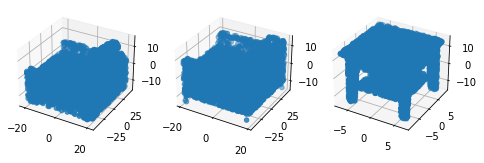

In [4]:
fig = plt.figure(figsize=plt.figaspect(0.5))
# fig.suptitle('Horizontally stacked subplots')
sample,label = pointcloudtrain_dataset[100]
#fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 3, 1, projection='3d')
surf = ax.scatter(sample[:, 0], sample[:, 1], sample[:, 2])


sample,label = pointcloudtrain_dataset[190]
ax = fig.add_subplot(1, 3, 2, projection='3d')

ax.scatter(sample[:, 0], sample[:, 1], sample[:, 2])

sample,label = pointcloudtrain_dataset[350]
ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.scatter(sample[:, 0], sample[:, 1], sample[:, 2])

plt.show()

In [5]:
from torch.utils.data.dataloader import default_collate

device = torch.device('cuda:0')  # or whatever device/cpu you like

# the new collate function is quite generic
trainloader = DataLoader(pointcloudtrain_dataset, batch_size=128, shuffle=True, 
                    collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))
testloader = DataLoader(pointcloudtest_dataset, batch_size=128, shuffle=False, 
                    collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x)))



# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [6]:
dataiter = iter(testloader)

points, labels = dataiter.next()
print(points.shape)

torch.Size([128, 5000, 3])


In [7]:
import torch.nn as nn
import torch.nn.functional as F

class PointNet(nn.Module):
    def __init__(self):
        super(PointNet, self).__init__()

        self.weight1 = nn.Parameter(torch.eye(3,device=torch.device('cuda:0')))
        self.weight2 = nn.Parameter(torch.eye(64,device=torch.device('cuda:0')))
        
        self.fc1 = nn.Sequential(nn.Linear(3,64),nn.BatchNorm1d(5000))
        self.fc2 = nn.Sequential(nn.Linear(64,64),nn.BatchNorm1d(5000))
        
        
        self.fc3 = nn.Sequential(nn.Linear(64,64),nn.BatchNorm1d(5000))
        self.fc4 = nn.Sequential(nn.Linear(64,128),nn.BatchNorm1d(5000))
        self.fc5 = nn.Sequential(nn.Linear(128,1024),nn.BatchNorm1d(5000))
        
        
        self.fc6 = nn.Sequential(nn.Linear(1024,512),nn.BatchNorm1d(512))
        self.fc7 = nn.Sequential(nn.Linear(512,256),nn.BatchNorm1d(256))
        self.fc8 = nn.Sequential(nn.Linear(256,10))
        
    def matrix1(self,x):
        return torch.matmul(x, self.weight1)
    
    def matrix2(self,x):
        return torch.matmul(x, self.weight2)
    
    
    def forward(self, x):
        # first transformation to the input
        x = self.matrix1(x)
        
        
        #batch size should not be multiplied
        x = nn.Flatten(2, -1)(x)
        
#        fully connected layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

#         second transformatino to the input
        x = self.matrix2(x)
        
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        
        x, max_indices = torch.max(x, dim=1)
        
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = F.relu(self.fc8(x))
        
        return x


In [8]:
Network = PointNet()
Network.cuda()
torch.cuda.current_device()

0

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Network.parameters(), lr=0.001, momentum=0.9)
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()


In [10]:
total_step = len(trainloader)
startepoch = 0
torch.cuda.synchronize()
for epoch in range(startepoch,20):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device,dtype=torch.float), labels.to(device,dtype=torch.float)
#         inputs,labels = inputs.float(),labels.float()
        optimizer.zero_grad()
        outputs = Network(inputs)

        loss = criterion(outputs, labels).to(device)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    torch.save({
            'epoch': epoch,
            'model_state_dict': Network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, "model.pth")

    if (epoch+1) % 1 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
            .format(epoch+1, 20, i+1, total_step, loss.item()))
print('Finished Training')


Epoch [1/20], Step [32/32], Loss: 1.9262
Epoch [2/20], Step [32/32], Loss: 1.7311
Epoch [3/20], Step [32/32], Loss: 1.7837
Epoch [4/20], Step [32/32], Loss: 1.4289
Epoch [5/20], Step [32/32], Loss: 1.5637
Epoch [6/20], Step [32/32], Loss: 0.7920
Epoch [7/20], Step [32/32], Loss: 0.9345
Epoch [8/20], Step [32/32], Loss: 0.9022
Epoch [9/20], Step [32/32], Loss: 0.9812
Epoch [10/20], Step [32/32], Loss: 0.9160
Epoch [11/20], Step [32/32], Loss: 1.2299
Epoch [12/20], Step [32/32], Loss: 0.6100
Epoch [13/20], Step [32/32], Loss: 0.7260
Epoch [14/20], Step [32/32], Loss: 0.8116
Epoch [15/20], Step [32/32], Loss: 0.7578
Epoch [16/20], Step [32/32], Loss: 0.5904
Epoch [17/20], Step [32/32], Loss: 0.6638
Epoch [18/20], Step [32/32], Loss: 0.5559
Epoch [19/20], Step [32/32], Loss: 0.7868
Epoch [20/20], Step [32/32], Loss: 0.9059
Finished Training


### Evaluation

In [11]:
Network.eval()
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device,dtype=torch.float), labels.to(device,dtype=torch.float)
        # calculate outputs by running images through the network
        outputs = Network(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 31 %


In [12]:
torch.cuda.empty_cache()